### 要求：
1.	具体要求如下图所示：
    - 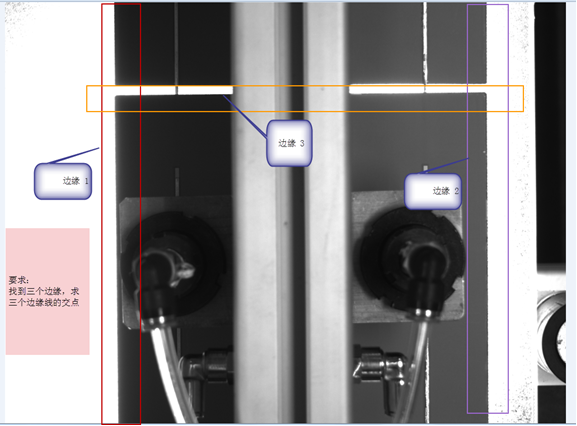
2.	算法尽量通用，参数调整好后，其他图像都可以使用；
3.	代码使用VC/C++/python实现，可借助库实现，如opencv等；
4.	算法以及实现必须独立完成。如无法全部完成，可以提供部分结果；
5.	需提供：
    - 算法思路；
    - 程序结果；
    - 程序；


#### 算法思路
1. 图像先转换成灰度图
2. 基于Canny来寻找边界
    - 观察发现左边的第一条垂直边界是从白色区域进入到黑色(深色)区域，可用阈值检测和梯度变化来选择出这一条边界
    - 右边和上边的边界同理，可通过相同的方法选择出对应的边界
3. 绘制轮廓
    - 根据上一步选择出来的点集，可以绘制出边界

#### 逐行列扫描，找出梯度变化较大的行与列

左侧扫描范围: x = 172 到 1296
  候选左线 x=439: 总分=31.5 (结构=3.4, 连续=60, 强变化=0)
  候选左线 x=442: 总分=43.0 (结构=3.9, 连续=67, 强变化=0)
  候选左线 x=444: 总分=44.1 (结构=4.3, 连续=55, 强变化=0)
  候选左线 x=446: 总分=45.6 (结构=4.6, 连续=51, 强变化=0)
  候选左线 x=450: 总分=48.3 (结构=5.1, 连续=47, 强变化=0)
  候选左线 x=453: 总分=48.8 (结构=5.4, 连续=42, 强变化=2)
  候选左线 x=454: 总分=53.3 (结构=5.4, 连续=53, 强变化=2)
  候选左线 x=456: 总分=54.8 (结构=5.4, 连续=66, 强变化=0)


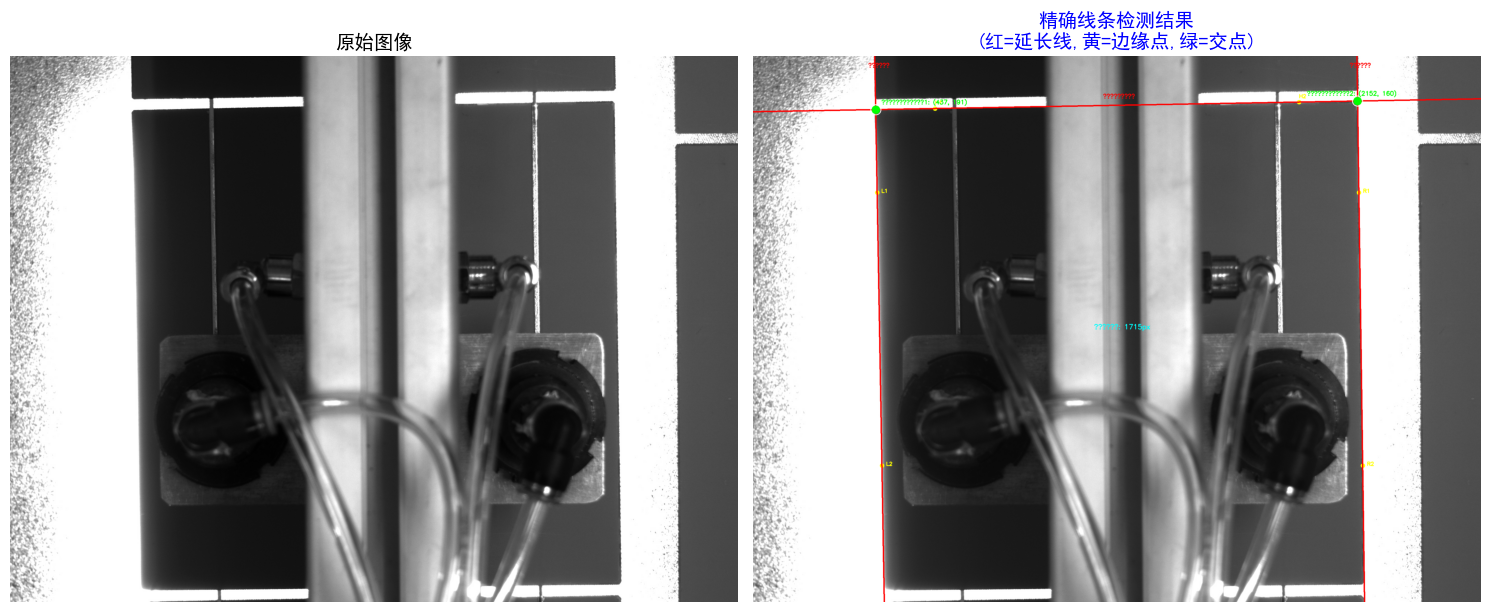

In [1]:
# 基于明暗交接点重绘精确线条
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams["axes.unicode_minus"] = False

def find_optimized_contours(img):
    """
    优化的轮廓线检测：解决边缘噪音干扰问题
    主要改进：
    1. 排除图像边缘噪音区域
    2. 基于结构特征的验证
    3. 垂直连续性检测
    4. 多重评分机制
    """
    height, width = img.shape
    
    # 计算梯度
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Canny边缘检测
    edges = cv2.Canny(img, 80, 150)
    
    # === 优化的左侧垂直线检测 ===
    left_line = None
    max_confidence = 0
    
    # 动态边缘排除区域 - 这是关键改进
    EDGE_MARGIN = max(120, width // 15)  # 至少120像素的边缘排除区域
    
    print(f"左侧扫描范围: x = {EDGE_MARGIN} 到 {width//2}")
    
    for x in range(EDGE_MARGIN, width//2):
        # 1. 边缘统计
        edge_count = 0
        strong_transitions = 0
        
        for y in range(height//4, 3*height//4):
            if edges[y, x] > 0:
                edge_count += 1
            
            # 检测强度变化（使用窗口平均，减少噪音）
            if x < width - 8:
                # 左侧窗口（应该是亮区域）
                left_window = img[max(0, y-1):min(height, y+2), max(0, x-3):x+1]
                # 右侧窗口（应该是暗区域）  
                right_window = img[max(0, y-1):min(height, y+2), x+2:min(width, x+8)]
                
                if left_window.size > 0 and right_window.size > 0:
                    left_avg = np.mean(left_window)
                    right_avg = np.mean(right_window)
                    intensity_diff = left_avg - right_avg
                    
                    if intensity_diff > 100:  # 从亮到暗的强变化
                        strong_transitions += 1
        
        # 2. 垂直连续性检查
        edge_segments = []
        current_segment = 0
        
        for y in range(height//6, 5*height//6):
            has_edge = (edges[y, x] > 0 or 
                       (x < width-3 and abs(int(img[y, x]) - int(img[y, x+3])) > 70))
            
            if has_edge:
                current_segment += 1
            else:
                if current_segment >= 5:  # 至少5个连续点才算有效段
                    edge_segments.append(current_segment)
                current_segment = 0
        
        if current_segment >= 5:
            edge_segments.append(current_segment)
        
        max_continuity = max(edge_segments) if edge_segments else 0
        
        # 3. 结构验证：检查是否为真正的从亮到暗的边界
        structure_score = 0
        if x >= 30 and x < width - 30:
            # 左侧大区域（应该较亮）
            left_region = img[height//4:3*height//4, max(0, x-30):x-5]
            # 右侧大区域（应该较暗）
            right_region = img[height//4:3*height//4, x+5:min(width, x+35)]
            
            if left_region.size > 100 and right_region.size > 100:
                left_avg = np.mean(left_region)
                right_avg = np.mean(right_region)
                brightness_diff = left_avg - right_avg
                
                if brightness_diff > 80:  # 确实是从亮到暗的结构
                    structure_score = min(brightness_diff / 30, 8)  # 限制最大分数
        
        # 4. 综合评分（重新调整权重）
        confidence = (structure_score * 4 +      # 结构特征最重要
                     max_continuity * 0.3 +      # 垂直连续性
                     strong_transitions * 1.5 +  # 强度变化
                     edge_count * 0.2)           # 基础边缘
        
        if confidence > max_confidence and confidence > 30:  # 降低阈值
            max_confidence = confidence
            left_line = x
            print(f"  候选左线 x={x}: 总分={confidence:.1f} (结构={structure_score:.1f}, 连续={max_continuity}, 强变化={strong_transitions})")
    
    # === 右侧垂直线检测（保持相对简单） ===
    # 寻找右侧垂直线（白→灰）
    right_line = None
    max_edge_count = 0
    
    for x in range(width - 50, width//2, -1):
        edge_count = 0
        intensity_changes = 0
        
        for y in range(height//4, 3*height//4):
            if edges[y, x] > 0:
                edge_count += 1
                
            if x > 0:
                current = img[y, x]
                prev_px = img[y, x - 1]
                if abs(int(current) - int(prev_px)) > 80:  # 较小的阈值用于灰色变化
                    intensity_changes += 1
        
        total_score = edge_count + intensity_changes * 2
        if total_score > max_edge_count and total_score > 20:
            max_edge_count = total_score
            right_line = x
    
    # === 水平线检测（轻微优化） ===
    horizontal_line = None
    max_confidence = 0
    WHITE_THRESHOLD = 170
    DARK_THRESHOLD = 110
    
    for y in range(EDGE_MARGIN//2, height - EDGE_MARGIN//2):
        edge_count = 0
        white_to_dark_transitions = 0
        
        for x in range(width//4, 3*width//4):
            if edges[y, x] > 0:
                edge_count += 1
                
            if y < height - 8:
                # 使用窗口平均
                up_window = img[max(0, y-5):y, max(0, x-2):min(width, x+3)]
                down_window = img[y+3:min(height, y+8), max(0, x-2):min(width, x+3)]
                
                if up_window.size > 0 and down_window.size > 0:
                    up_avg = np.mean(up_window)
                    down_avg = np.mean(down_window)
                    
                    if up_avg >= WHITE_THRESHOLD and down_avg <= DARK_THRESHOLD:
                        white_to_dark_transitions += 3
                    elif up_avg - down_avg > 60:
                        white_to_dark_transitions += 1
        
        confidence = edge_count * 0.5 + white_to_dark_transitions * 1.8
        if confidence > max_confidence and confidence > 20:
            max_confidence = confidence
            horizontal_line = y
        
    return left_line, right_line, horizontal_line, edges, gradient_magnitude


def find_edge_points_near_lines(img, left_x, right_x, horizontal_y, search_range=20):
    """
    在已检测线条附近寻找明暗交接处的精确点
    
    参数:
    - img: 灰度图像
    - left_x, right_x, horizontal_y: 已检测到的线条位置
    - search_range: 搜索范围（像素）
    
    返回:
    - 每条线上的两个关键点坐标
    """
    height, width = img.shape
    
    # 计算梯度用于检测明暗交接
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    
    def find_strongest_edge_in_region(center_x, center_y, direction, search_range):
        """在指定区域内寻找最强的边缘点"""
        max_gradient = 0
        best_point = (center_x, center_y)
        
        if direction == 'vertical':  # 垂直线，在x方向搜索
            for dx in range(-search_range, search_range + 1):
                x = center_x + dx
                if 0 <= x < width:
                    # 检查该x位置的梯度强度
                    gradient_sum = 0
                    count = 0
                    for y in range(max(0, center_y - 50), min(height, center_y + 51)):
                        if gradient_magnitude[y, x] > 50:  # 阈值过滤
                            gradient_sum += gradient_magnitude[y, x]
                            count += 1
                    
                    if count > 0:
                        avg_gradient = gradient_sum / count
                        if avg_gradient > max_gradient:
                            max_gradient = avg_gradient
                            best_point = (x, center_y)
        
        elif direction == 'horizontal':  # 水平线，在y方向搜索
            for dy in range(-search_range, search_range + 1):
                y = center_y + dy
                if 0 <= y < height:
                    # 检查该y位置的梯度强度
                    gradient_sum = 0
                    count = 0
                    for x in range(max(0, center_x - 50), min(width, center_x + 51)):
                        if gradient_magnitude[y, x] > 50:
                            gradient_sum += gradient_magnitude[y, x]
                            count += 1
                    
                    if count > 0:
                        avg_gradient = gradient_sum / count
                        if avg_gradient > max_gradient:
                            max_gradient = avg_gradient
                            best_point = (center_x, y)
        
        return best_point
    
    # 为每条线寻找两个关键点
    points_dict = {}
    
    # 左垂直线的两个点
    if left_x is not None:
        # 上方点（y坐标较小）
        upper_y = height // 4
        point1 = find_strongest_edge_in_region(left_x, upper_y, 'vertical', search_range)
        
        # 下方点（y坐标较大）
        lower_y = 3 * height // 4
        point2 = find_strongest_edge_in_region(left_x, lower_y, 'vertical', search_range)
        
        points_dict['left_line'] = [point1, point2]
    
    # 右垂直线的两个点
    if right_x is not None:
        # 上方点
        upper_y = height // 4
        point1 = find_strongest_edge_in_region(right_x, upper_y, 'vertical', search_range)
        
        # 下方点
        lower_y = 3 * height // 4
        point2 = find_strongest_edge_in_region(right_x, lower_y, 'vertical', search_range)
        
        points_dict['right_line'] = [point1, point2]
    
    # 水平线的两个点
    if horizontal_y is not None:
        # 左侧点
        left_x_pos = width // 4
        point1 = find_strongest_edge_in_region(left_x_pos, horizontal_y, 'horizontal', search_range)
        
        # 右侧点
        right_x_pos = 3 * width // 4
        point2 = find_strongest_edge_in_region(right_x_pos, horizontal_y, 'horizontal', search_range)
        
        points_dict['horizontal_line'] = [point1, point2]
    
    return points_dict

def create_refined_visualization(img, original_left, original_right, original_horizontal, 
                               edge_points, edges, gradient_mag):
    """基于边缘关键点创建精细化的可视化结果"""
    
    # 创建结果图像
    result = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    height, width = img.shape
    
    line_thickness = 3
    point_radius = 8
    
    refined_lines = {}
    
    def extend_line_through_image(point1, point2, img_width, img_height):
        """将两点连线延长到覆盖整个图像"""
        x1, y1 = point1
        x2, y2 = point2
        
        # 处理垂直线的情况（避免除零错误）
        if x2 - x1 == 0:
            # 垂直线，延长到图像顶部和底部
            return [(x1, 0), (x1, img_height - 1)]
        
        # 处理水平线的情况
        if y2 - y1 == 0:
            # 水平线，延长到图像左右边缘
            return [(0, y1), (img_width - 1, y1)]
        
        # 计算直线方程 y = mx + b
        m = (y2 - y1) / (x2 - x1)  # 斜率
        b = y1 - m * x1  # y轴截距
        
        # 找到直线与图像边界的交点
        intersections = []
        
        # 与左边界的交点 (x=0)
        y_left = b
        if 0 <= y_left <= img_height - 1:
            intersections.append((0, int(y_left)))
        
        # 与右边界的交点 (x=width-1)
        y_right = m * (img_width - 1) + b
        if 0 <= y_right <= img_height - 1:
            intersections.append((img_width - 1, int(y_right)))
        
        # 与顶边界的交点 (y=0)
        if m != 0:  # 避免水平线重复计算
            x_top = -b / m
            if 0 <= x_top <= img_width - 1:
                intersections.append((int(x_top), 0))
        
        # 与底边界的交点 (y=height-1)
        if m != 0:  # 避免水平线重复计算
            x_bottom = (img_height - 1 - b) / m
            if 0 <= x_bottom <= img_width - 1:
                intersections.append((int(x_bottom), img_height - 1))
        
        # 返回距离最远的两个交点
        if len(intersections) >= 2:
            return intersections[:2]
        else:
            return [point1, point2]  # 如果计算失败，返回原始点
    
    # 绘制基于边缘点的延长线条
    if 'left_line' in edge_points:
        points = edge_points['left_line']
        # 绘制关键点
        for i, point in enumerate(points):
            cv2.circle(result, point, point_radius, (0, 255, 255), -1)  # 黄色点
            cv2.putText(result, f'L{i+1}', (point[0] + 15, point[1]), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
        
        # 基于两点绘制延长线条
        if len(points) == 2:
            # 计算延长线的端点
            extended_points = extend_line_through_image(points[0], points[1], width, height)
            
            # 绘制延长的线条
            cv2.line(result, extended_points[0], extended_points[1], (0, 0, 255), line_thickness)
            
            # 临时存储线段信息，真正的交点将在后面计算
            refined_lines['left_points'] = points
            
            # 添加标签（使用平均x坐标作为标签位置）
            avg_x = int((points[0][0] + points[1][0]) / 2)
            cv2.putText(result, f'左线', (avg_x - 40, 40), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    if 'right_line' in edge_points:
        points = edge_points['right_line']
        # 绘制关键点
        for i, point in enumerate(points):
            cv2.circle(result, point, point_radius, (0, 255, 255), -1)
            cv2.putText(result, f'R{i+1}', (point[0] + 15, point[1]), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
        
        # 基于两点绘制延长线条
        if len(points) == 2:
            # 计算延长线的端点
            extended_points = extend_line_through_image(points[0], points[1], width, height)
            
            # 绘制延长的线条
            cv2.line(result, extended_points[0], extended_points[1], (0, 0, 255), line_thickness)
            
            # 临时存储线段信息，真正的交点将在后面计算
            refined_lines['right_points'] = points
            
            # 添加标签（使用平均x坐标作为标签位置）
            avg_x = int((points[0][0] + points[1][0]) / 2)
            cv2.putText(result, f'右线', (avg_x - 40, 40), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    if 'horizontal_line' in edge_points:
        points = edge_points['horizontal_line']
        # 绘制关键点
        for i, point in enumerate(points):
            cv2.circle(result, point, point_radius, (0, 255, 255), -1)
            cv2.putText(result, f'H{i+1}', (point[0], point[1] - 15), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
        
        # 基于两点绘制延长线条
        if len(points) == 2:
            # 计算延长线的端点
            extended_points = extend_line_through_image(points[0], points[1], width, height)
            
            # 绘制延长的线条
            cv2.line(result, extended_points[0], extended_points[1], (0, 0, 255), line_thickness)
            
            # 临时存储线段信息，真正的交点将在后面计算
            refined_lines['horizontal_points'] = points
            
            # 添加标签（使用平均y坐标作为标签位置）
            avg_y = int((points[0][1] + points[1][1]) / 2)
            cv2.putText(result, f'水平线', (width//2 - 50, avg_y - 25), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    def calculate_line_intersection(line1_points, line2_points):
        """计算两条线的精确交点"""
        # 线1的两个点
        (x1, y1), (x2, y2) = line1_points
        # 线2的两个点
        (x3, y3), (x4, y4) = line2_points
        
        # 计算分母
        denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
        
        if abs(denom) < 1e-10:  # 线条平行
            return None
        
        # 使用线性方程组求解交点
        t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / denom
        
        # 计算交点坐标
        intersection_x = x1 + t * (x2 - x1)
        intersection_y = y1 + t * (y2 - y1)
        
        return (int(round(intersection_x)), int(round(intersection_y)))
    
    # 计算并绘制新的精确交点
    intersections = []  # 存储交点信息
    
    # 左垂直线与水平线的交点
    if 'left_points' in refined_lines and 'horizontal_points' in refined_lines:
        left_points = refined_lines['left_points']
        horizontal_points = refined_lines['horizontal_points']
        
        intersection = calculate_line_intersection(left_points, horizontal_points)
        if intersection:
            cv2.circle(result, intersection, 15, (0, 255, 0), -1)  # 更大的绿色交点
            cv2.circle(result, intersection, 18, (255, 255, 255), 2)  # 白色边框突出显示
            cv2.putText(result, f'精确交点1: {intersection}', 
                       (intersection[0] + 20, intersection[1] - 20), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            intersections.append(('左垂直线与水平线交点', intersection))
            refined_lines['left'] = intersection[0]  # 更新精确的x坐标
            if 'horizontal' not in refined_lines:  # 只在第一次设置
                refined_lines['horizontal'] = intersection[1]
    
    # 右垂直线与水平线的交点
    if 'right_points' in refined_lines and 'horizontal_points' in refined_lines:
        right_points = refined_lines['right_points']
        horizontal_points = refined_lines['horizontal_points']
        
        intersection = calculate_line_intersection(right_points, horizontal_points)
        if intersection:
            cv2.circle(result, intersection, 15, (0, 255, 0), -1)  # 更大的绿色交点
            cv2.circle(result, intersection, 18, (255, 255, 255), 2)  # 白色边框突出显示
            cv2.putText(result, f'精确交点2: {intersection}', 
                       (intersection[0] - 180, intersection[1] - 20), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            intersections.append(('右垂直线与水平线交点', intersection))
            refined_lines['right'] = intersection[0]  # 更新精确的x坐标
            if 'horizontal' not in refined_lines:  # 只在第一次设置
                refined_lines['horizontal'] = intersection[1]
    
    # 如果存在左右垂直线，也可以计算它们与图像边界的"虚拟交点"
    if 'left' in refined_lines and 'right' in refined_lines:
        # 计算两条垂直线之间的距离
        distance = abs(refined_lines['right'] - refined_lines['left'])
        
        # 在图像中央添加距离信息
        mid_x = (refined_lines['left'] + refined_lines['right']) // 2
        cv2.putText(result, f'宽度: {distance}px', 
                   (mid_x - 80, height // 2), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2)
    
    return result, refined_lines, intersections

# 使用之前检测到的线条位置
img = cv2.imread('OpenCV_test/Cam0-6.jpg', cv2.IMREAD_GRAYSCALE)
left_opt, right_opt, horizontal_opt, edges_opt, grad_mag_opt = find_optimized_contours(img)
if 'left_opt' in locals() and 'right_opt' in locals() and 'horizontal_opt' in locals():
    # 寻找边缘关键点
    edge_points = find_edge_points_near_lines(img, left_opt, right_opt, horizontal_opt, search_range=25)
    
    # 创建精细化可视化
    refined_result, refined_lines, precise_intersections = create_refined_visualization(
        img, left_opt, right_opt, horizontal_opt, edge_points, edges_opt, grad_mag_opt)
    
    # 显示结果
    plt.figure(figsize=(15, 8))
    
    # 原始图像
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('原始图像', fontsize=14)
    plt.axis('off')
    
    # 精细化检测结果
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(refined_result, cv2.COLOR_BGR2RGB))
    plt.title('精确线条检测结果\n(红=延长线,黄=边缘点,绿=交点)', fontsize=14, weight='bold', color='blue')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("错误：需要先运行前面的检测算法获取初始线条位置！")